# AI Model for Physics Project
## Task 1


## Introduction to the project
The goal of this project is to build a Graph Neural Network (GNN) to study spin glass systems. A spin glass is a magnetic system that can be represented as a graph, where the nodes are the spins and the edges represent the interactions between the spins. 
The energy of the system is given by the Hamiltonian of the system. The magnetization of the system is the sum of the spins. 
The GNN will be trained in a supervised way, where the target will be the energy or the magnetization of the system.

The project is divided into 2 tasks:
1. Build a GNN to learn the energy of the system and study how the learning changes with the connectivity of the graph and with the magnetic field. Then also a brief comparison with the magnetization as a target will follow.
2. Compare how GNNs learn the energy and magnetization of the system compared to MLPs (Multi Layer Perceptrons).

In this notebook you can find Task 1. While in the next notebook you can find Task 2.



- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)




## Building the Graph

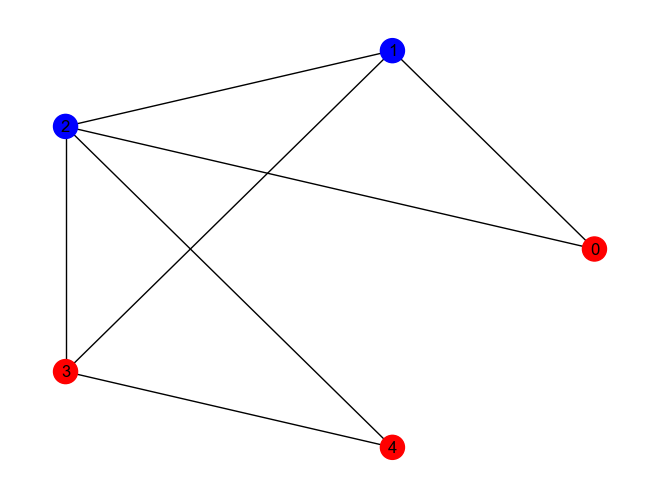

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
import torch
from torch_geometric.utils import to_networkx, from_networkx

def initialize_graph(L, periodic= False, dimensions =2):
    """
    Initialize a graph with L nodes, each with a random spin and random weights on the edges.
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
        if periodic:
            for j in range(i+1, i+dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
    

    

def plot_graph(G, pos= None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    nx.draw(G,pos = pos, node_color=colors, with_labels=True)
    plt.show()
    
L = 5
G = initialize_graph(L)
plot_graph(G)


## Energy and Magnetization Calculation
They will be used to create the datasets

In [4]:
def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting
print(calculate_energy(G, h = 0.5))

0.5041457500402071


In [5]:
def calculate_magnetization(G):
    """
    Calculate the magnetization of the graph
    """
    return np.sum([G.nodes[i]["spin"] for i in G.nodes])

## Dataset

In [6]:
#Creating a dataset of graphs in Data format with energy as target
def create_dataset(L, num_samples, h=0, periodic=True, dimension=2):
    """
    Create a dataset of graphs with L nodes and num_samples samples
    """
    dataset = []
    graphs = []
    energies = []
    for i in range(num_samples):
        G = initialize_graph(L, periodic, dimension)
        E = calculate_energy(G, h)
        A = nx.adjacency_matrix(G).todense()
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        data = Data(x= X, edge_index = torch.tensor(np.array(G.edges)).T , edge_weight =torch.tensor([G[i][j]["weight"] for i, j in G.edges]),
                    y = torch.tensor([E]).float())
        dataset.append(data)
        graphs.append(G)
        energies.append(data.y)
        
    return dataset, energies, graphs 




Let's create a single dataset in order to check whether the GNN will be able to learn the energy of the graph

In [10]:
trainset, energies, graphs  = create_dataset(25, 5000)  #Training set
valset, val_energies, val_graphs = create_dataset(25, 2000) #Validation set



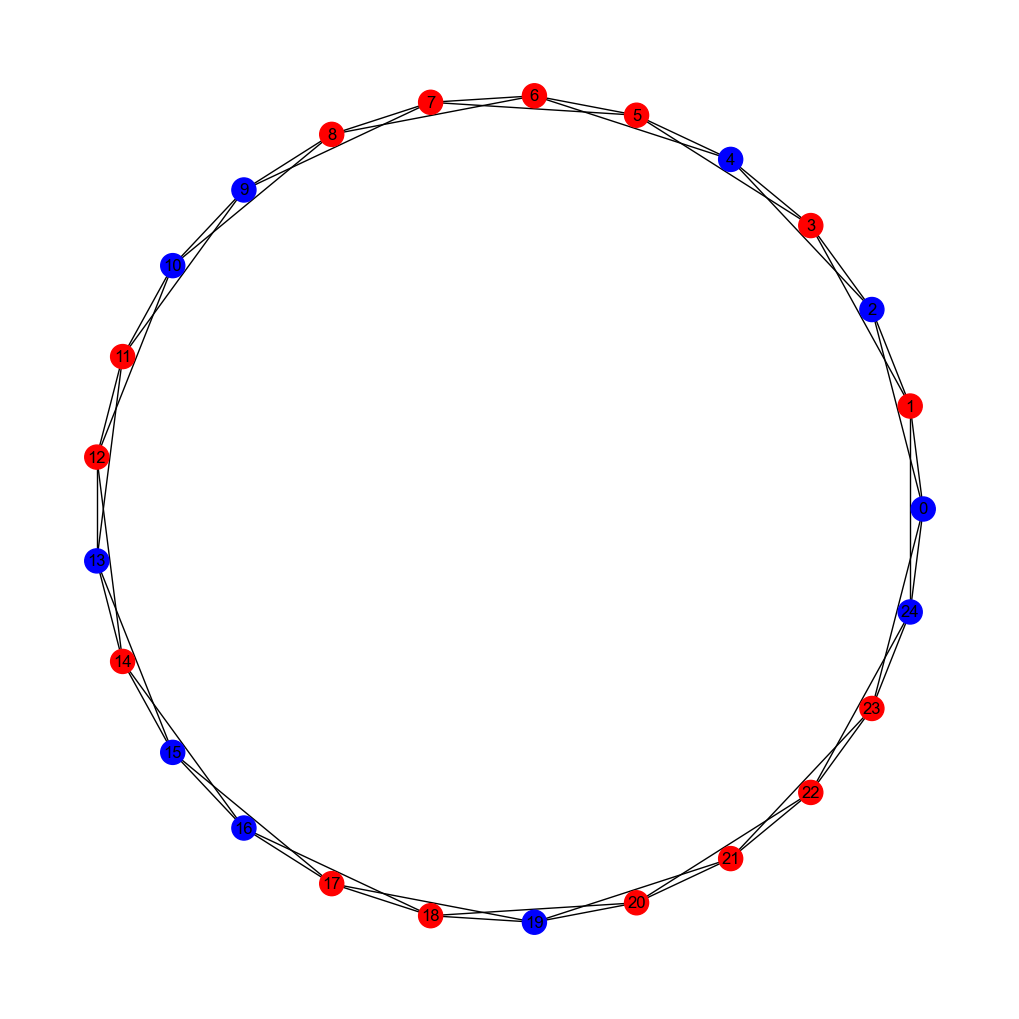

tensor([-2.3609])
Data(x=[25, 1], edge_index=[2, 50], y=[1], edge_weight=[50])


In [12]:
#Plot the first graph for visualization
plt.figure(figsize=(5, 5))
plot_graph((graphs[0]))
print(energies[0])
print(trainset[6])

Try to only use 1 convolutional layer

## GNN model
Defining the GNN model that will be used to learn the energy of the graph

In [7]:
# GNN model
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_max_pool
from torch_geometric.data import Data



class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(1 , 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 64)
        self.conv4 = GraphConv(64, 64)
        self.conv5 = GraphConv(64, 32)
        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, 1)
        self.dropout = torch.nn.Dropout(0.4)
        #Criterion
        self.criterion = torch.nn.MSELoss()
        
        #Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight 
        batch_index = data.batch
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv5(x, edge_index, edge_weight))
        x = global_max_pool(x, batch_index)
        #Flatten the tensor
        x = x.view(-1, 32)      
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_step(self, data):
        self.optimizer.zero_grad()
        out = self.forward(data)
        loss = self.criterion(out, data.y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    



In [8]:
#Summary to check the number of parameters
summarygnn = GNN()
#summary
sum(p.numel() for p in summarygnn.parameters() )


18193

## Training the model

In [16]:
from torch_geometric.data import DataLoader

trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

gnn = GNN()

train_plot = []
val_plot = []
best_loss = 100
for epoch in (range(20)):
    #Training
    gnn.train()
    losses = []
    for data in (trainloader):
        data = data
        loss = gnn.train_step(data)
        losses.append(loss)
    print("Epoch ", epoch, "Training Loss: ", sum(losses)/len(losses))
    train_plot.append(sum(losses)/len(losses))
    
    #Validation
    gnn.eval()
    val_losses = []
    for data in valloader:       
        val_losses.append(gnn.criterion(gnn.forward(data), data.y).item())
    if sum(val_losses)/len(val_losses) < best_loss:
        best_loss = sum(val_losses)/len(val_losses)
        torch.save(gnn.state_dict(), "best_model.pth")
        
    print("Epoch ",epoch,"Validation loss: ", sum(val_losses)/len(val_losses))
    val_plot.append(sum(val_losses)/len(val_losses))
    

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 Training Loss:  1.9749553154533879
Epoch  0 Validation loss:  1.0202159410538014
Epoch  1 Training Loss:  1.3023980099824586
Epoch  1 Validation loss:  0.8273861032791048
Epoch  2 Training Loss:  1.104761841737003
Epoch  2 Validation loss:  0.8135612790845208
Epoch  3 Training Loss:  1.0545391015706644
Epoch  3 Validation loss:  0.7091724055582236
Epoch  4 Training Loss:  0.9705669502644301
Epoch  4 Validation loss:  0.645652398106374
Epoch  5 Training Loss:  0.9347742621086763
Epoch  5 Validation loss:  0.8797944047387918
Epoch  6 Training Loss:  0.9159981722918387
Epoch  6 Validation loss:  1.3656957502211258
Epoch  7 Training Loss:  0.9009971563810777
Epoch  7 Validation loss:  0.6566736848927057
Epoch  8 Training Loss:  0.8449225652258586
Epoch  8 Validation loss:  0.5898462484315226
Epoch  9 Training Loss:  0.8321476376694481
Epoch  9 Validation loss:  0.5761642738238918
Epoch  10 Training Loss:  0.8285915574552318
Epoch  10 Validation loss:  0.539575278742344
Epoch  11 T

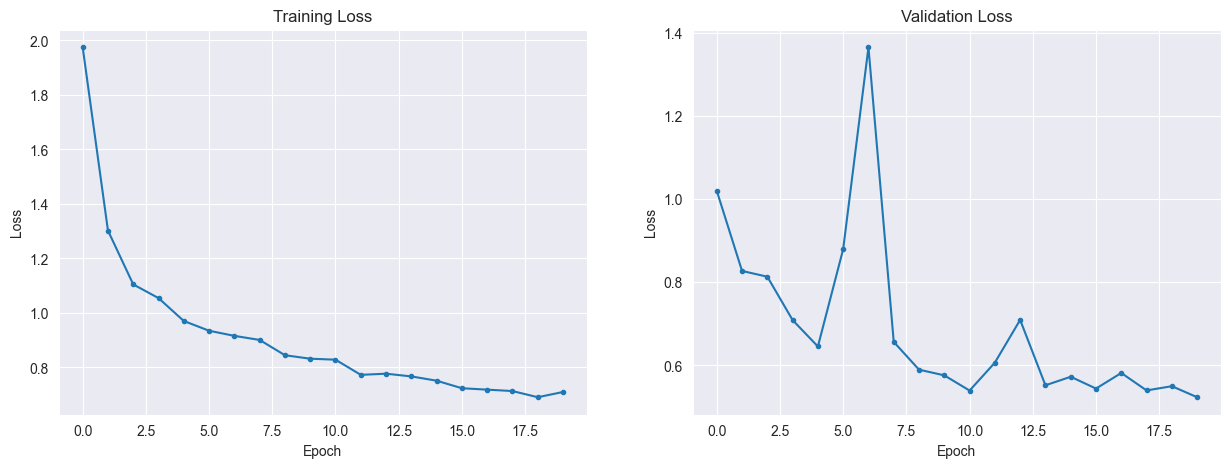

In [17]:
#Plot of the training and validation loss 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_plot, ".-")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(val_plot, ".-")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Cycle over the different datasets
The number of spins will stay fixed while the connections will change. We will cycle over the different datasets and train the same model on each of them separately. We will then plot the training and validation loss for each dataset. We will also save the validation loss for each dataset to compare them at the end.

In [10]:
#Creating the datasets, they will vary in both the number of connections and in external magnetic field
from torch_geometric.data import DataLoader
h_values = [0, 0.5, 1, 1.5]
datasets = {}
valsets = {}
trainloaders = {}
valloaders = {}

for i, num_dimensions in enumerate([1, 2, 3, 4, 5]):
    for j, h_val in enumerate(h_values):
        dataset, _, _ = create_dataset(25, 8000, h = h_val, dimension = num_dimensions)
        valset, _, _ = create_dataset(25, 2000, h = h_val, dimension = num_dimensions)
        datasets[(i, j)] = dataset
        valsets[(i, j)] = valset
        trainloaders[(i, j)] = DataLoader(dataset, batch_size=1, shuffle=True)
        valloaders[(i, j)] = DataLoader(valset, batch_size=1, shuffle=False)

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
#Training the model on each dataset
#Saving loss values for each dataset

best_losses = {}
train_plotss = {}
val_plotss = {}
for i in range(5):
    for j in range(4):
        best_loss = 100
        gnn = GNN()
        train_plot = []
        val_plot = []
        for epoch in (range(20)):
            #Training
            gnn.train()
            losses = []
            for data in (trainloaders[(i, j)]):
                data = data
                loss = gnn.train_step(data)
                losses.append(loss)
            print("Epoch ", epoch, "Training Loss: ", sum(losses)/len(losses))
            train_plot.append(sum(losses)/len(losses))

            #Validation
            gnn.eval()
            val_losses = []
            for data in valloaders[(i, j)]:       
                val_losses.append(gnn.criterion(gnn.forward(data), data.y).item())
            if sum(val_losses)/len(val_losses) < best_loss:
                best_loss = sum(val_losses)/len(val_losses)

            print("Epoch ",epoch,"Validation loss: ", sum(val_losses)/len(val_losses))
            val_plot.append(sum(val_losses)/len(val_losses))
        best_losses[(i, j)] = best_loss
        train_plotss[(i, j)] = train_plot
        val_plotss[(i, j)] = val_plot

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 Training Loss:  1.0052668584791573
Epoch  0 Validation loss:  0.7197758952397507
Epoch  1 Training Loss:  0.6570344288032802
Epoch  1 Validation loss:  0.40782687049476307
Epoch  2 Training Loss:  0.5789749002724182
Epoch  2 Validation loss:  0.4079599892069653
Epoch  3 Training Loss:  0.49982234602520403
Epoch  3 Validation loss:  0.44738805698698625
Epoch  4 Training Loss:  0.48096288847905366
Epoch  4 Validation loss:  0.33170614233424023
Epoch  5 Training Loss:  0.4444090796225205
Epoch  5 Validation loss:  0.2905288799256506
Epoch  6 Training Loss:  0.43115527261175535
Epoch  6 Validation loss:  0.2674517675294496
Epoch  7 Training Loss:  0.41693023404877355
Epoch  7 Validation loss:  0.2463017862370695
Epoch  8 Training Loss:  0.39399460407481457
Epoch  8 Validation loss:  0.3536034000587463
Epoch  9 Training Loss:  0.3925602166408686
Epoch  9 Validation loss:  0.24447132293184376
Epoch  10 Training Loss:  0.3757437192329563
Epoch  10 Validation loss:  0.2425224446276695

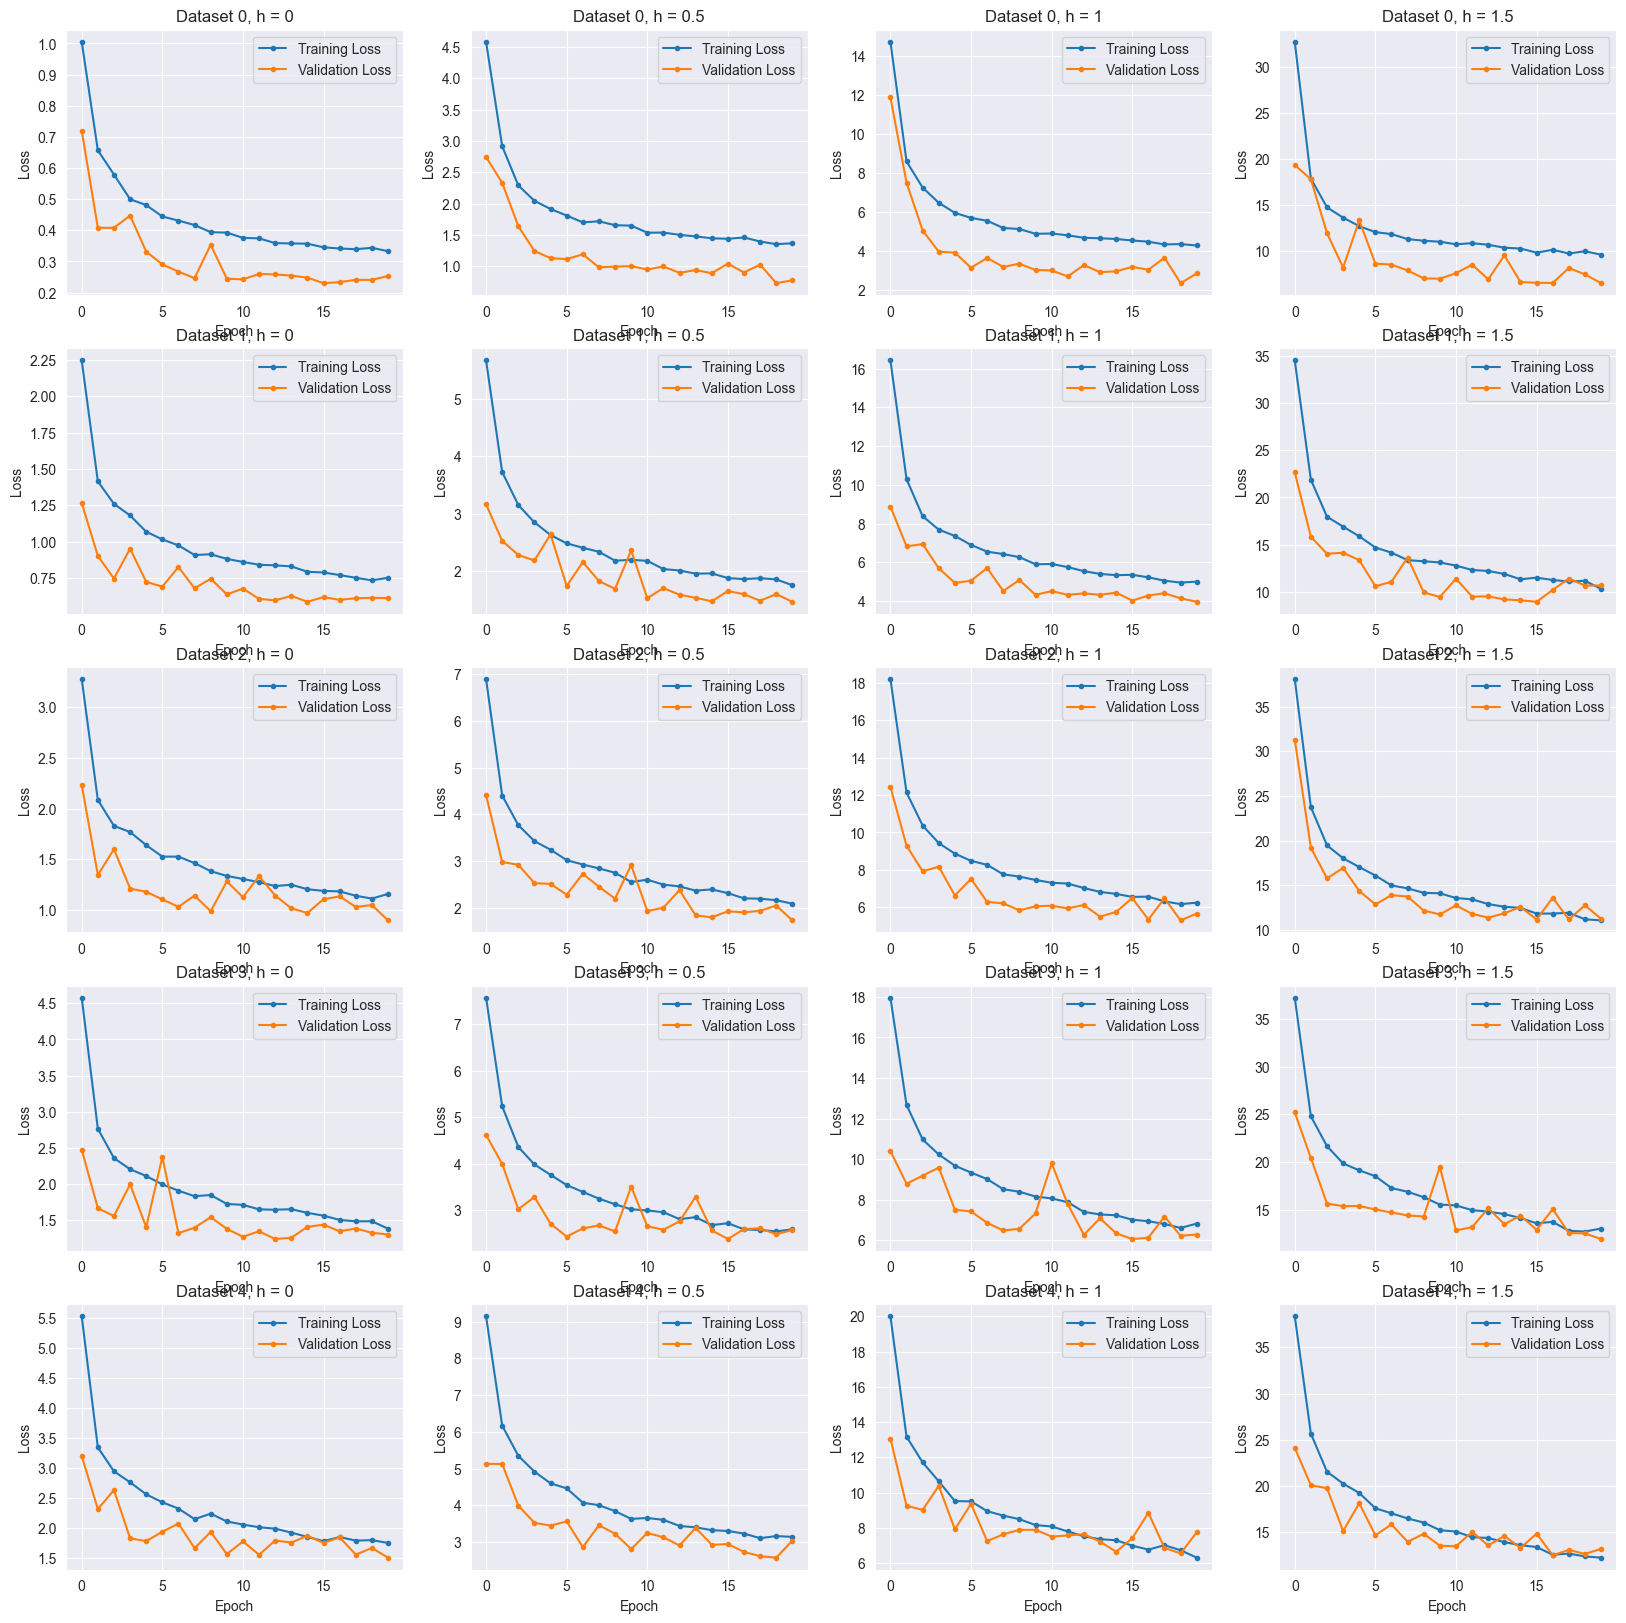

In [12]:
#Plotting the training and validation loss for each dataset
plt.figure(figsize=(20, 20))
for i in range(5):
    for j in range(4):
        plt.subplot(5, 4, 4*i+j+1)
        plt.plot(train_plotss[(i, j)], ".-", label = "Training Loss")
        plt.plot(val_plotss[(i, j)], ".-", label = "Validation Loss")
        plt.title(f"Dataset {i}, h = {h_values[j]}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()


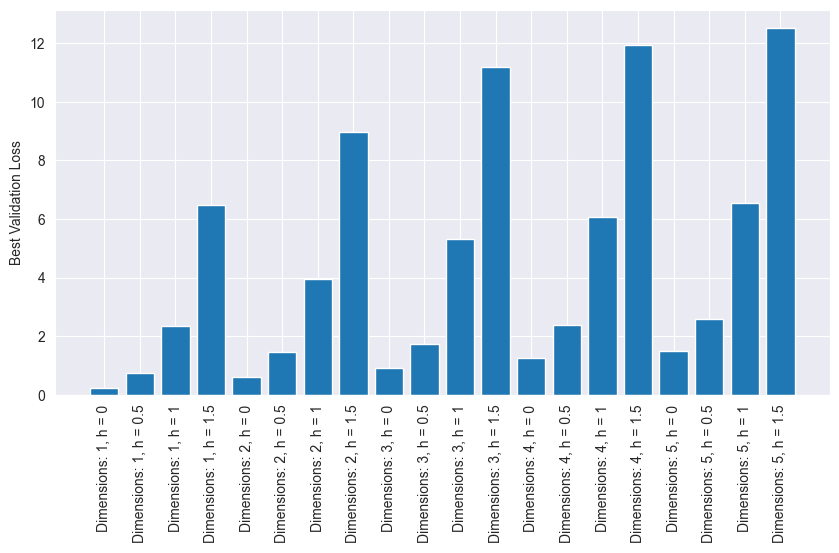

In [13]:
#Comparing the best validation losses for each dataset
#Using a bar plot for better visualization
plt.figure(figsize=(10, 5))
plt.bar(range(20), [best_losses[(i, j)] for i in range(5) for j in range(4)])
plt.xticks(range(20), [f"Dimensions: {i+1}, h = {h_values[j]}" for i in range(5) for j in range(4)], rotation=90)
plt.ylabel("Best Validation Loss")
plt.show()

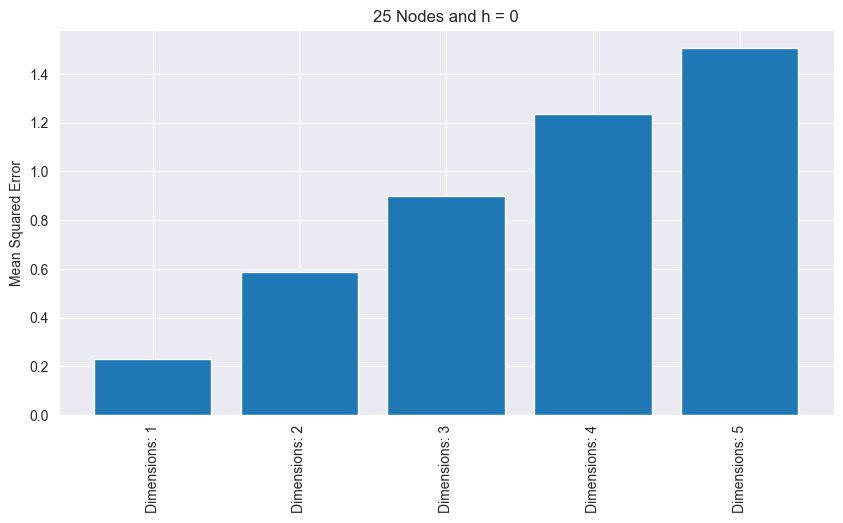

In [14]:
#Plotting only the datasets for h = 0
plt.figure(figsize=(10, 5))
plt.bar(range(5), [best_losses[(i, 0)] for i in range(5)])
plt.xticks(range(5), [f"Dimensions: {i+1}" for i in range(5)], rotation=90)
plt.ylabel("Mean Squared Error")
plt.title("25 Nodes and h = 0")
plt.show()

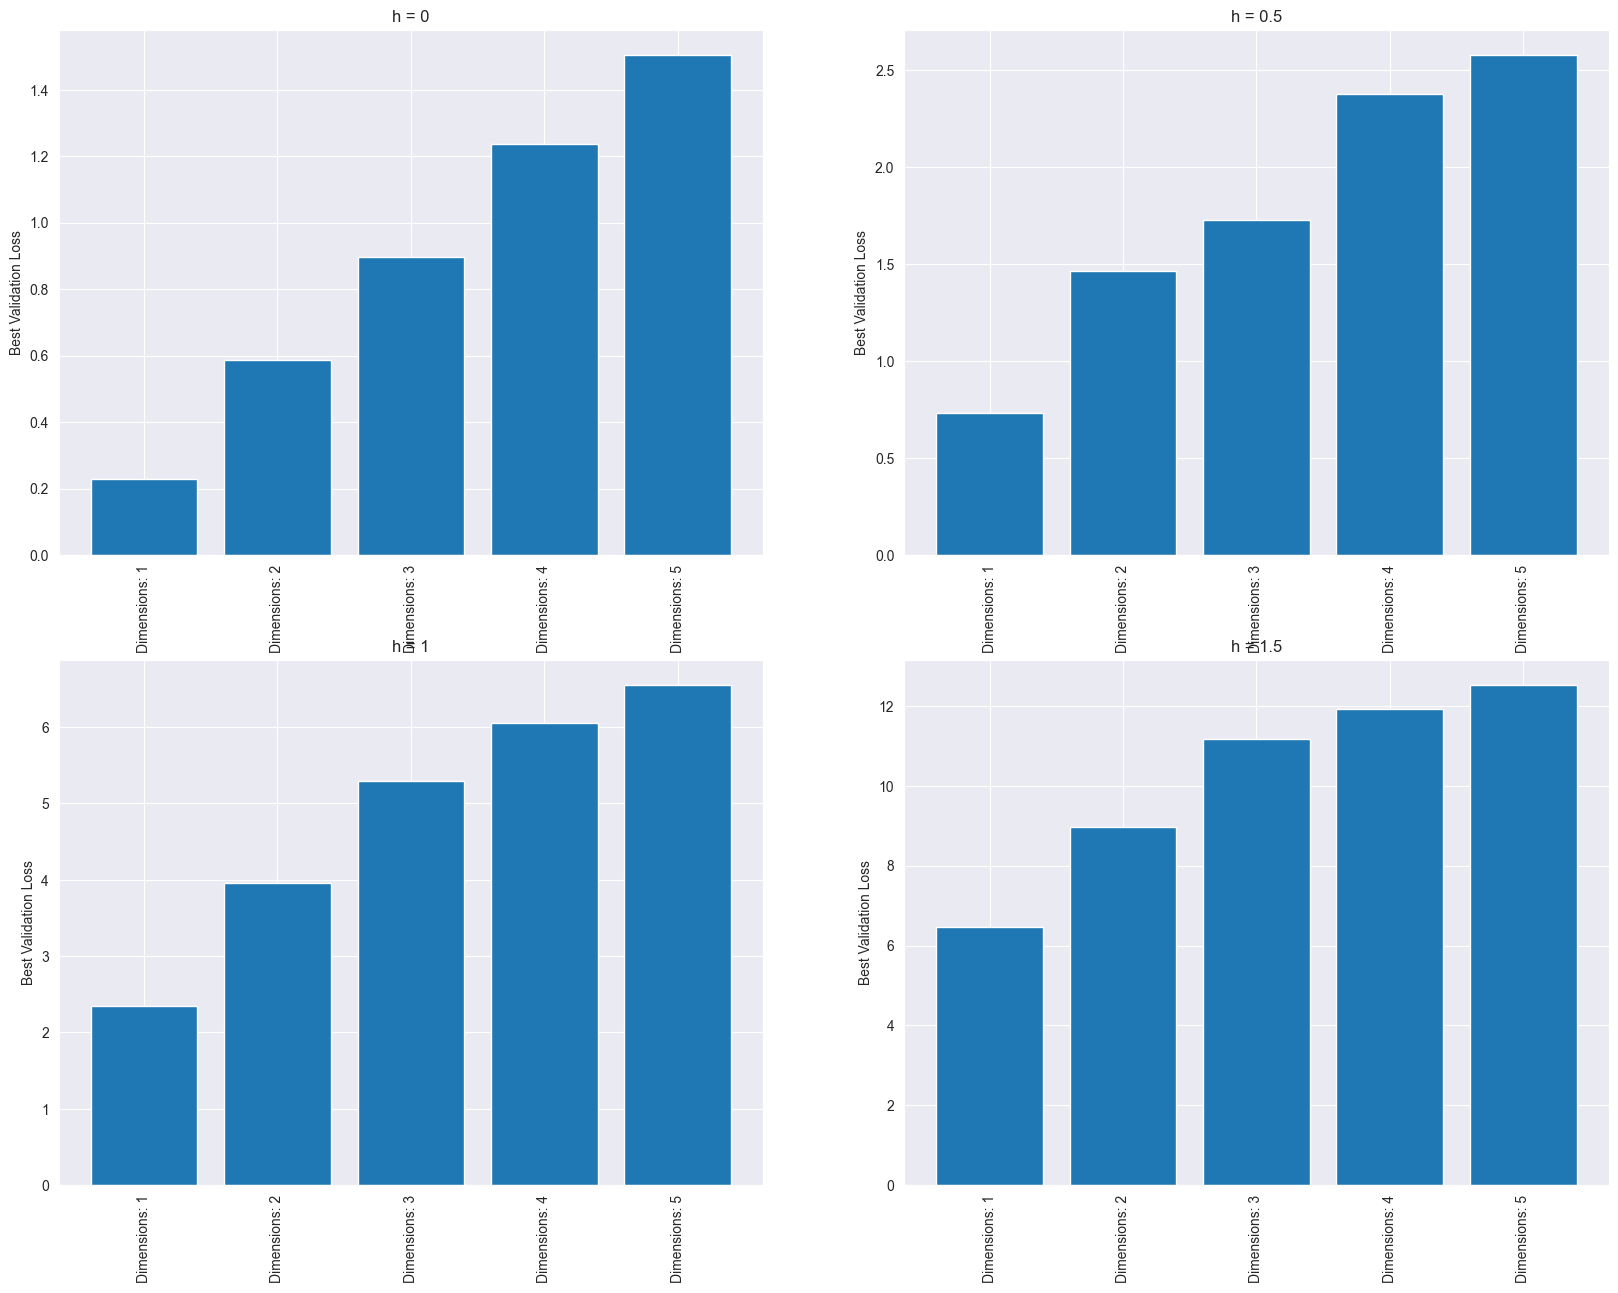

In [15]:
#Compare the best validation losses for each dataset at fixed h in a bar plot for each h value in a separate subplot
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(range(5), [best_losses[(j, i)] for j in range(5)])
    plt.xticks(range(5), [f"Dimensions: {j+1}" for j in range(5)], rotation=90)
    plt.ylabel(f"Best Validation Loss")
    plt.title(f"h = {h_values[i]}")


# Magnetization
Let's see how the learning of magnetization changes with two different datasets

In [16]:
#Build a dataset with magnetization as target
def create_dataset_magnetization(L, num_samples, h=0, periodic=True, dimension=2):
    """
    Create a dataset of graphs with L nodes and num_samples samples
    """
    dataset = []
    graphs = []
    magnetizations = []
    for i in range(num_samples):
        G = initialize_graph(L, periodic, dimension)
        M = calculate_magnetization(G)
        A = nx.adjacency_matrix(G).todense()
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        data = Data(x= X, edge_index = torch.tensor(np.array(G.edges)).T , edge_weight =torch.tensor([G[i][j]["weight"] for i, j in G.edges]),
                    y = torch.tensor([M]).float())
        dataset.append(data)
        graphs.append(G)
        magnetizations.append(data.y)
        
    return dataset, magnetizations, graphs

In [18]:
#Creating the two datasets
trainset_magnetization, magnetizations, _ = create_dataset_magnetization(25, 8000, h = 0 ,dimension= 2 )
valset_magnetization, val_magnetizations, _ = create_dataset_magnetization(25, 2000,h = 0 ,dimension= 2)

In [19]:
trainset_magnetization2, magnetizations2, _ = create_dataset_magnetization(25, 8000, h = 0 ,dimension= 4)
valset_magnetization2, val_magnetizations2, _ = create_dataset_magnetization(25, 2000, h = 0 ,dimension= 4)

In [20]:
#Training the model, using the same model as before
trainloader_magnetization = DataLoader(trainset_magnetization, batch_size=1, shuffle=True)
valloader_magnetization = DataLoader(valset_magnetization, batch_size=1, shuffle=False)

gnn_magnetization = GNN()

train_plot_magnetization = []
val_plot_magnetization = []
best_loss = 100
for epoch in (range(20)):
    #Training
    gnn_magnetization.train()
    losses = []
    for data in (trainloader_magnetization):
        loss = gnn_magnetization.train_step(data)
        losses.append(loss)
    print("Epoch ", epoch, "Training Loss: ", sum(losses)/len(losses))
    train_plot_magnetization.append(sum(losses)/len(losses))

    #Validation
    gnn_magnetization.eval()
    val_losses = []
    for data in valloader_magnetization:       
        val_losses.append(gnn_magnetization.criterion(gnn_magnetization.forward(data), data.y).item())
    if sum(val_losses)/len(val_losses) < best_loss:
        best_loss = sum(val_losses)/len(val_losses)
        torch.save(gnn_magnetization.state_dict(), "best_model_magnetization.pth")

    print("Epoch ",epoch,"Validation loss: ", sum(val_losses)/len(val_losses))
    val_plot_magnetization.append(sum(val_losses)/len(val_losses))

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 Training Loss:  13.922365039602267
Epoch  0 Validation loss:  7.2036965097019365
Epoch  1 Training Loss:  8.923895582660569
Epoch  1 Validation loss:  7.29194389258126
Epoch  2 Training Loss:  7.713824728160649
Epoch  2 Validation loss:  4.761013977507646
Epoch  3 Training Loss:  7.016202723169043
Epoch  3 Validation loss:  4.173517420772216
Epoch  4 Training Loss:  6.5464054087665335
Epoch  4 Validation loss:  4.135348977725709
Epoch  5 Training Loss:  6.275239546205515
Epoch  5 Validation loss:  4.0992446542396905
Epoch  6 Training Loss:  6.032852266902272
Epoch  6 Validation loss:  6.488211039975765
Epoch  7 Training Loss:  5.775105950520696
Epoch  7 Validation loss:  4.338195706874261
Epoch  8 Training Loss:  5.499545477649883
Epoch  8 Validation loss:  3.75475220353841
Epoch  9 Training Loss:  5.4396270410809295
Epoch  9 Validation loss:  3.8208044882740024
Epoch  10 Training Loss:  5.1679057015114855
Epoch  10 Validation loss:  3.3349783074340023
Epoch  11 Training Loss:

In [21]:
trainloader_magnetization2 = DataLoader(trainset_magnetization2, batch_size=1, shuffle=True)
valloader_magnetization2 = DataLoader(valset_magnetization2, batch_size=1, shuffle=False)

gnn_magnetization2 = GNN()

train_plot_magnetization2 = []
val_plot_magnetization2 = []
best_loss = 100
for epoch in (range(20)):
    #Training
    gnn_magnetization2.train()
    losses = []
    for data in (trainloader_magnetization2):
        loss = gnn_magnetization2.train_step(data)
        losses.append(loss)
    print("Epoch ", epoch, "Training Loss: ", sum(losses)/len(losses))
    train_plot_magnetization2.append(sum(losses)/len(losses))

    #Validation
    gnn_magnetization2.eval()
    val_losses = []
    for data in valloader_magnetization2:       
        val_losses.append(gnn_magnetization2.criterion(gnn_magnetization2.forward(data), data.y).item())
    if sum(val_losses)/len(val_losses) < best_loss:
        best_loss = sum(val_losses)/len(val_losses)
        torch.save(gnn_magnetization2.state_dict(), "best_model_magnetization2.pth")

    print("Epoch ",epoch,"Validation loss: ", sum(val_losses)/len(val_losses))
    val_plot_magnetization2.append(sum(val_losses)/len(val_losses))

Epoch  0 Training Loss:  14.879100013720665
Epoch  0 Validation loss:  8.58820500806326
Epoch  1 Training Loss:  9.330253928412832
Epoch  1 Validation loss:  7.005843074409224
Epoch  2 Training Loss:  8.278284650465901
Epoch  2 Validation loss:  6.761893171520583
Epoch  3 Training Loss:  7.708643725132618
Epoch  3 Validation loss:  6.740325079373433
Epoch  4 Training Loss:  7.390654721828227
Epoch  4 Validation loss:  6.208440150941964
Epoch  5 Training Loss:  7.055407411954496
Epoch  5 Validation loss:  5.587742495221731
Epoch  6 Training Loss:  6.743556276584297
Epoch  6 Validation loss:  5.868911988128239
Epoch  7 Training Loss:  6.494308223899259
Epoch  7 Validation loss:  5.288674738971185
Epoch  8 Training Loss:  6.315490642828309
Epoch  8 Validation loss:  6.217951820593071
Epoch  9 Training Loss:  6.0435691669926435
Epoch  9 Validation loss:  5.481697050105709
Epoch  10 Training Loss:  5.994897467609559
Epoch  10 Validation loss:  6.191466808355758
Epoch  11 Training Loss:  5.7

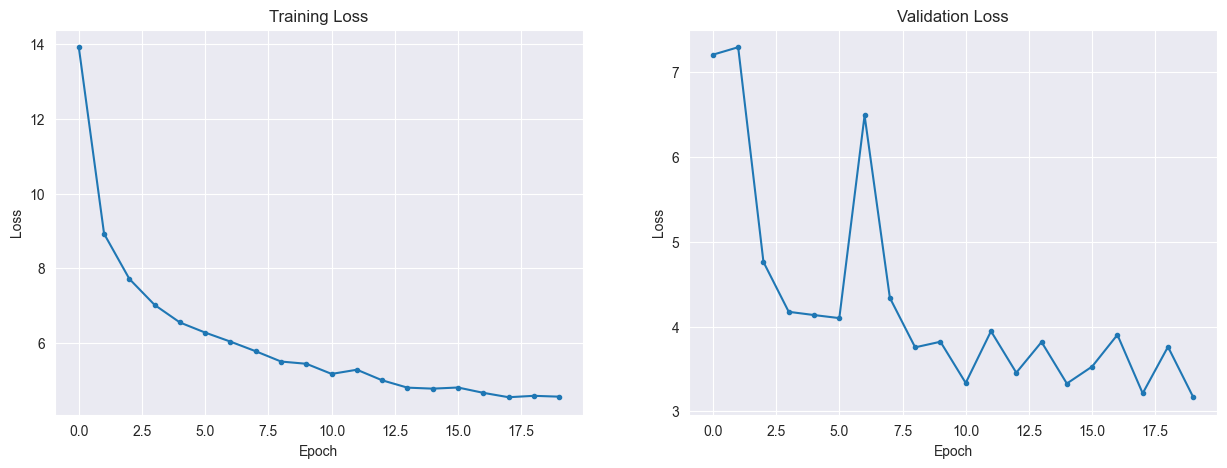

In [22]:
#Plotting the training and validation loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_plot_magnetization, ".-")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(val_plot_magnetization, ".-")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

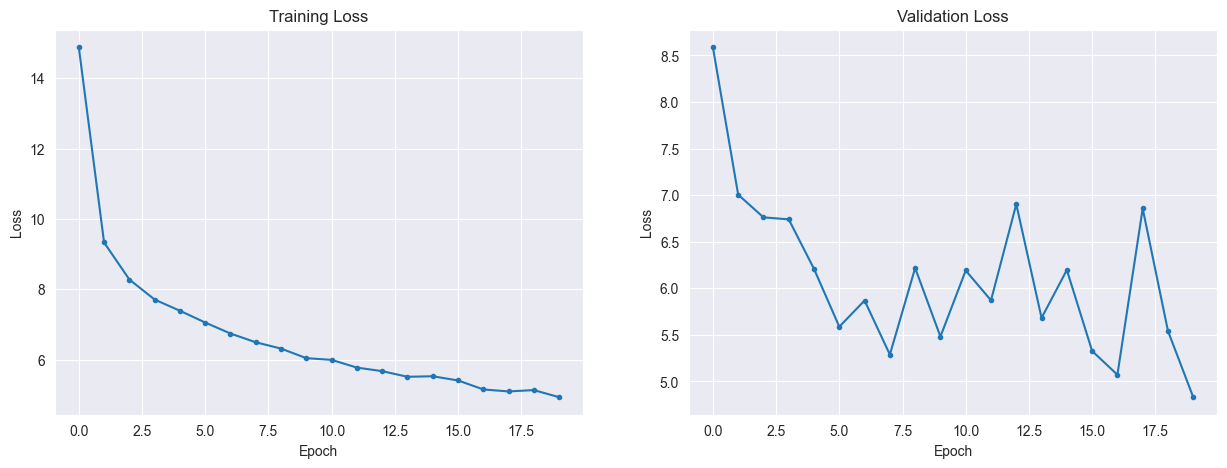

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_plot_magnetization2, ".-")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(val_plot_magnetization2, ".-")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [24]:
#Comparing the two lowest validation losses
min(val_plot_magnetization), min(val_plot_magnetization2)

(3.166844522326758, 4.831024129593743)